In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data Processing
---

In [7]:
df = pd.read_csv('car_launch_data_5.txt', header=1, delim_whitespace=True)
print(df)
print(df.columns)

        t      x      y
0   0.000  0.132  1.178
1   0.033  0.223  1.261
2   0.067  0.317  1.335
3   0.100  0.411  1.399
4   0.133  0.480  1.440
5   0.167  0.585  1.490
6   0.200  0.678  1.524
7   0.233  0.770  1.546
8   0.267  0.872  1.558
9   0.300  0.938  1.561
10  0.333  1.027  1.553
11  0.367  1.115  1.535
12  0.400  1.201  1.508
13  0.433  1.290  1.464
14  0.467  1.376  1.417
15  0.500  1.461  1.359
16  0.533  1.564  1.273
17  0.567  1.634  1.206
18  0.600  1.715  1.119
19  0.633  1.803  1.012
20  0.667  1.881  0.910
21  0.700  1.957  0.798
22  0.733  2.033  0.678
23  0.767  2.108  0.551
24  0.800  2.181  0.415
25  0.833  2.253  0.271
26  0.867  2.323  0.121
Index(['t', 'x', 'y'], dtype='object')


In [8]:
# move the lowest y to 0

m = min(df['y'])
df['y'] = df['y'].apply(lambda x: x-m)

# # make t start at 0
# t_offset = min(df['x'])
# df['t'] = df['t'].apply(lambda x: x-t_offset)

Text(0, 0.5, 'y')

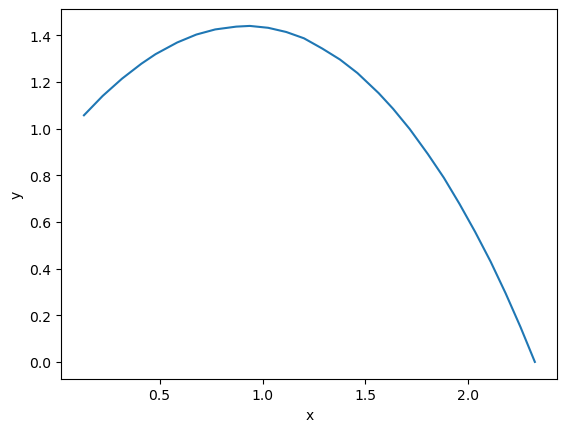

In [9]:
plt.plot(df['x'], df['y'])
plt.xlabel("x")
plt.ylabel("y")

Text(0, 0.5, 'y(t)')

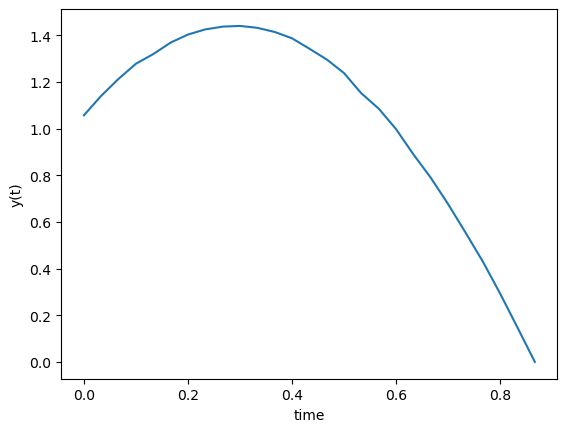

In [10]:
plt.plot(df['t'], df['y'])
plt.xlabel("time")
plt.ylabel("y(t)")

Text(0, 0.5, 'x(t)')

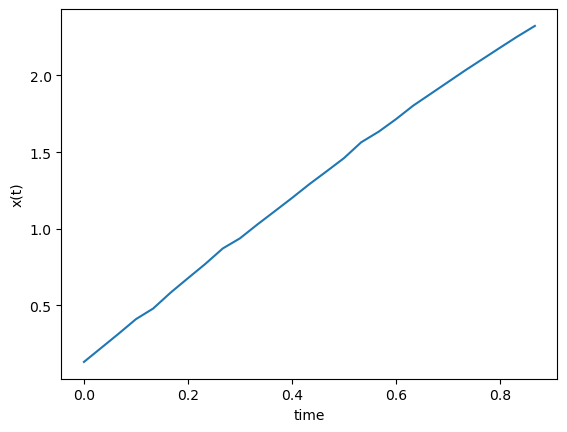

In [11]:
plt.plot(df['t'], df['x'])
plt.xlabel("time")
plt.ylabel("x(t)")

## Simulation Helpers

In [ ]:
# Constants
g   = 9.8               # gravity (m/s^2)

t0  = 0                 # initial Time (s)
 
dt  = .033              # time resolution
tf  = 0.867             # total time to simulate

nsteps = int(tf/dt) + 1 # number of time steps

In [13]:
## calculate inital conditions based on two given (early) coordinate points
def initial_conditions(coord1, coord2):
    t    = coord2[0] - coord1[0]
    x    = coord2[1] - coord1[1]
    y    = coord2[2] - coord1[2]
    return [x/t, y/t, coord1[1], coord1[2]]


i_coord = initial_conditions(df.loc[0], df.loc[1])
print(i_coord)


[2.7575757575757573, 2.515151515151514, 0.132, 1.057]


## Euler Method
---

In [12]:
## getting initial velocity components
## we need the first two points with different spatial coordinates
# for i in range(0, 5):
#     print("point", i)
#     print(df.loc[i].to_string(),'\n')

print(df.loc[1])
print(df.iloc[-1])

t    0.033
x    0.223
y    1.140
Name: 1, dtype: float64
t    0.867
x    2.323
y    0.000
Name: 26, dtype: float64


In [14]:
# Initial Conditions
 
y0  = i_coord[3]        # initial y (m)
x0  = i_coord[2]        # initial x (m)

vy0 = i_coord[1]        # iniital y velocity (m/s)
vx0 = i_coord[0]        # initial x velocity (m/s)

In [15]:
## setting up euler method time evolution
t = np.linspace(t0, tf, nsteps)

vx = np.zeros([nsteps])
vy = np.zeros([nsteps])
y  = np.zeros([nsteps])
x  = np.zeros([nsteps])

y[0]  = y0
x[0]  = x0
vy[0] = vy0
vx[0] = vx0

## time evolving
for i in range(0, nsteps-1):
    y[i+1]  = y[i] + dt * vy[i]
    vy[i+1] = vy[i] - dt * g

    x[i+1]  = x[i] + dt * vx[i]
    vx[i+1] = vx[i]


## Plots
---

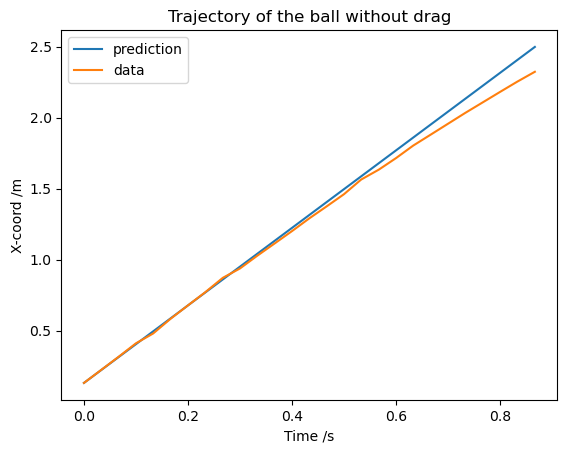

In [16]:
plt.plot(t, x, label="prediction")
plt.plot(df['t'], df['x'], label="data")
plt.plot()
plt.title('Trajectory of the ball without drag')
plt.xlabel('Time /s')
plt.ylabel('X-coord /m')
plt.legend()
plt.show()

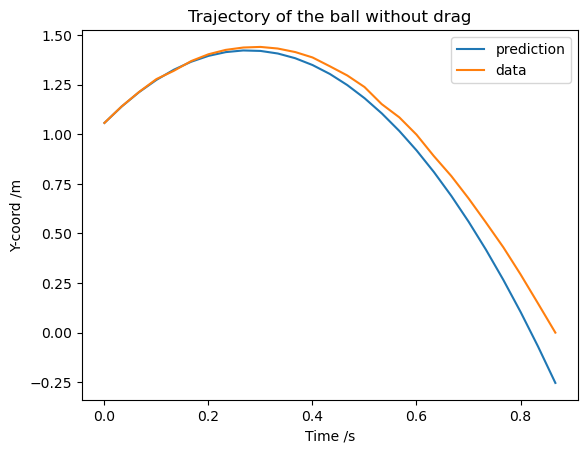

In [17]:
plt.plot(t, y, label="prediction")
plt.plot(df['t'], df['y'], label = "data")
plt.title('Trajectory of the ball without drag')
plt.xlabel('Time /s')
plt.ylabel('Y-coord /m')
plt.legend()
plt.show()

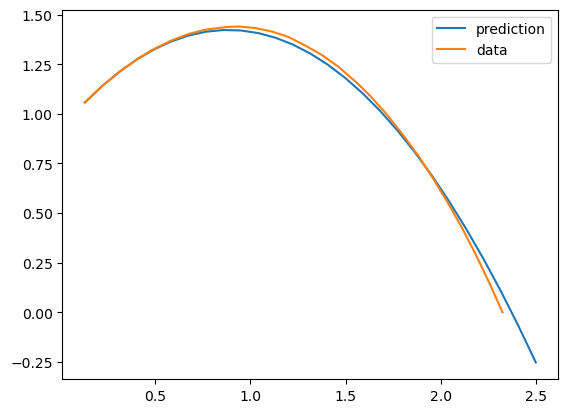

In [18]:
plt.plot(x,y, label="prediction")
plt.plot(df['x'], df['y'], label="data")
plt.legend()


## Error
---

In [19]:
def err(actual, expected):
    if not len(actual) == len(expected):
        return "number of data points do not match"
    else:
        return [round(abs(actual[i] - expected[i]), 5) if actual[i] > 0 and expected[i] > 0 else 0 for i in range(len(actual)) ]


        

In [20]:
x_data = df['x'].values
x_pred = x

y_data = df['y'].values
y_pred = y

print(len(x_data), len(x_pred))
print(x_data[-1], x_pred[-1])

print(len(y_data), len(y_pred))
print(y_data[-1], y_pred[-1])

27 27
2.323 2.4980000000000007
27 27
0.0 -0.2534650000000009


In [21]:
x_err = err(x_data, x_pred)
y_err = err(y_data, y_pred)
print(y_err)

[0.0, 0.0, 0.00167, 0.00402, 0.00597, 0.00372, 0.00808, 0.01112, 0.01482, 0.0202, 0.02525, 0.03097, 0.03837, 0.03943, 0.04817, 0.05658, 0.04766, 0.06842, 0.07985, 0.08195, 0.09972, 0.11816, 0.13928, 0.16407, 0.19053, 0, 0]


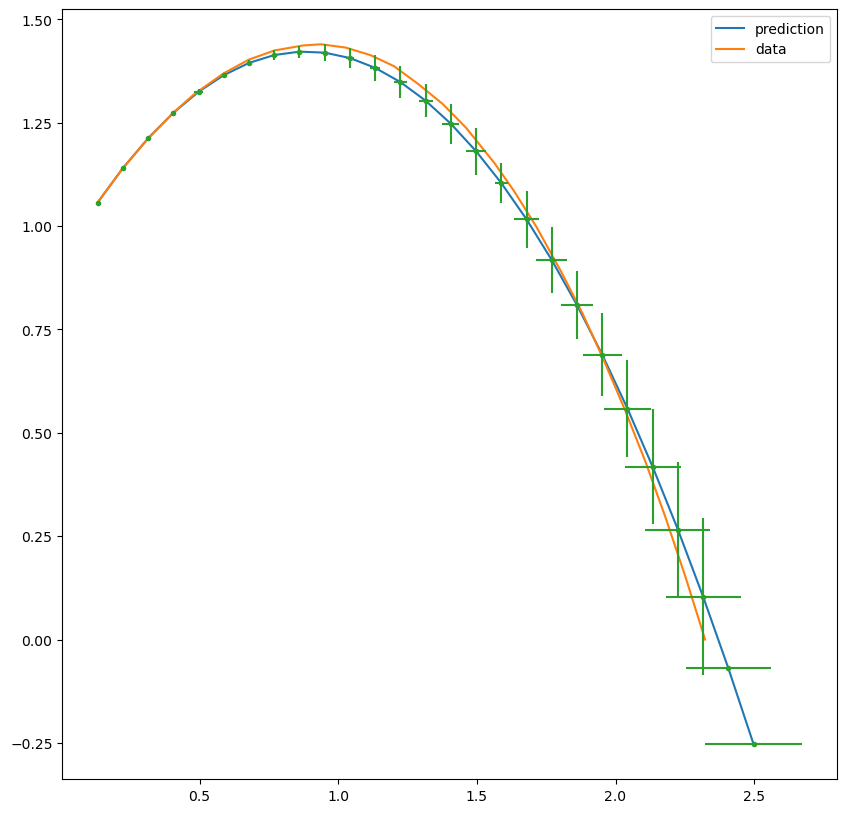

In [22]:
fig = plt.figure(figsize=(10, 10))
plt.plot(x,y, label="prediction")
plt.plot(df['x'], df['y'], label="data")
plt.errorbar(x, y, 
             xerr = x_err,
             yerr = y_err,
             fmt='.')

plt.legend()

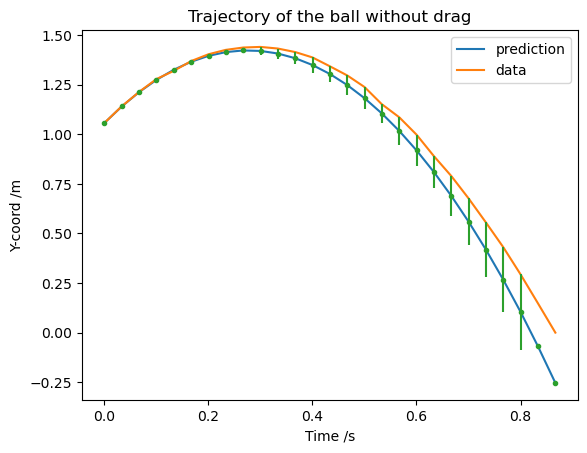

In [23]:
plt.plot(t, y, label="prediction")
plt.plot(df['t'], df['y'], label = "data")
plt.title('Trajectory of the ball without drag')
plt.xlabel('Time /s')
plt.ylabel('Y-coord /m')
plt.legend()
plt.errorbar(t, y, yerr=y_err, fmt='.')
plt.show()

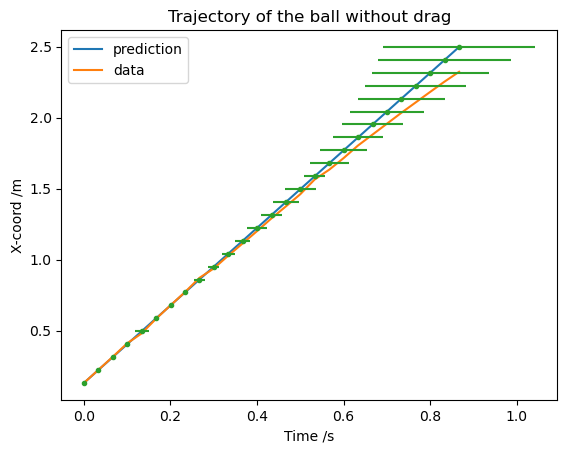

In [24]:
plt.plot(t, x, label="prediction")
plt.plot(df['t'], df['x'], label="data")
plt.plot()
plt.title('Trajectory of the ball without drag')
plt.xlabel('Time /s')
plt.ylabel('X-coord /m')
plt.errorbar(t, x, xerr=x_err, fmt='.')
plt.legend()
plt.show()

## Bashforth-Adams
---

The bashforth-adams algorithm is apparently an improvement on the Euler
algorithm so we will make an attempt at comparing them here

For a given position component, we have: <br>
$$ y_{n+1} = y_n + \frac{3}{2} \delta t f\left(t_n,y_n\right) - \frac{1}{2} \delta t f\left(t_{n-1},y_{n-1}\right)$$

It seems that most people are defining the function $f$ as the derivative of the
position component.

In [41]:
# BA Initial Conditions

i_coord0 = initial_conditions(df.loc[0], df.loc[1])
i_coord1 = initial_conditions(df.loc[1], df.loc[2])
    
y0  = i_coord0[3]        # initial y (m)
x0  = i_coord0[2]        # initial x (m)
vy0 = i_coord0[1]        # iniital y velocity (m/s)
vx0 = i_coord0[0]        # initial x velocity (m/s)

y1  = i_coord1[3]        # initial +1 y (m)
x1  = i_coord1[2]        # initial +1 x (m)
vy1 = i_coord1[1]        # iniital +1 y velocity (m/s)
vx1 = i_coord1[0]        # initial +1 x velocity (m/s)

print(i_coord0,i_coord1)


[2.7575757575757573, 2.515151515151514, 0.132, 1.057] [2.764705882352941, 2.1764705882352957, 0.223, 1.14]


In [37]:
## setting up euler method time evolution
t = np.linspace(t0, tf, nsteps)

vy_ba = np.zeros([nsteps])
vx_ba = np.zeros([nsteps])
y_ba  = np.zeros([nsteps])
x_ba  = np.zeros([nsteps])

y_ba[0]  = y0
x_ba[0]  = x0
y_ba[1]  = y1
x_ba[1]  = x1
vy_ba[0] = vy0
vx_ba[0] = vx0
vy_ba[1] = vy1
vx_ba[1] = vx1

In [87]:
## time evolving
for i in range(0, nsteps-2):
    y_ba[i+2]  = y_ba[i+1] + dt * (3/2*vy_ba[i+1] - 1/2*vy_ba[i])
    vy_ba[i+2] = vy_ba[i+1] - dt * g

    x_ba[i+2]  = x_ba[i+1] + dt * (3/2*vx_ba[i+1] - 1/2*vx_ba[i])
    vx_ba[i+2] = vx_ba[i]


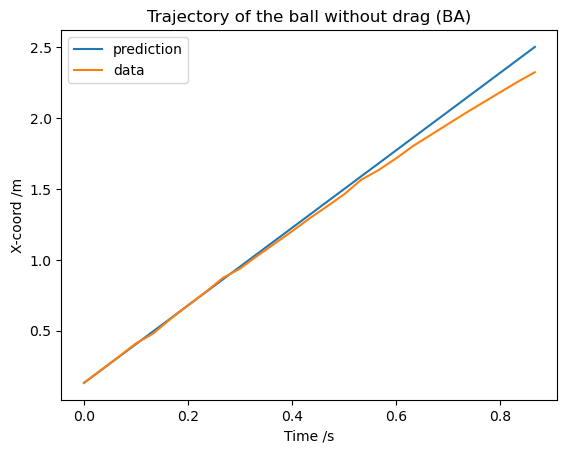

In [88]:
plt.plot(t, x_ba, label="prediction")
plt.plot(df['t'], df['x'], label="data")
plt.plot()
plt.title('Trajectory of the ball without drag (BA)')
plt.xlabel('Time /s')
plt.ylabel('X-coord /m')
plt.legend()
plt.show()

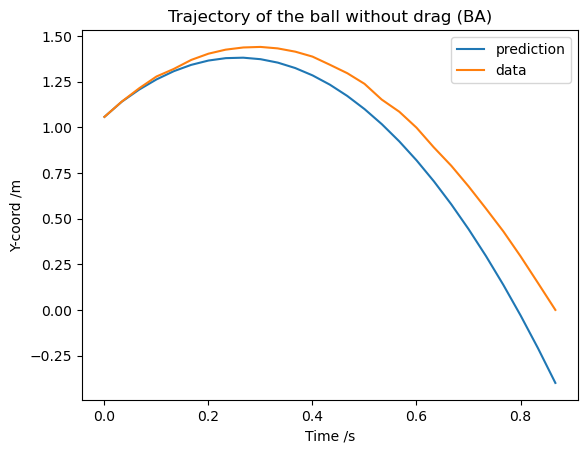

In [89]:
plt.plot(t, y_ba, label="prediction")
plt.plot(df['t'], df['y'], label = "data")
plt.title('Trajectory of the ball without drag (BA)')
plt.xlabel('Time /s')
plt.ylabel('Y-coord /m')
plt.legend()
plt.show()

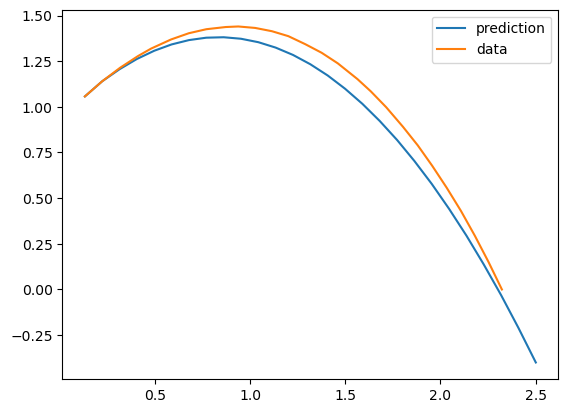

In [91]:
plt.plot(x_ba,y_ba, label="prediction")
plt.plot(df['x'], df['y'], label="data")
plt.legend()